# ⚛️ H₂ Ground-State VQE — Noisy Simulation

This notebook studies **VQE under realistic noise** via the API:

- `run_vqe_optimizer_comparison`
- `run_vqe`

The goal is to understand how noise affects:

- Optimizer stability  
- Convergence  
- The final **noisy density matrix**  
- Basis-state populations  

Noise model (identical for all optimizers):
- **Depolarizing:** 5%  
- **Amplitude damping:** 5%  

These values are intentionally exaggerated to make behavioural differences clear.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from vqe.core import run_vqe_optimizer_comparison, run_vqe

# Noise settings
depolarizing_prob = 0.05
amplitude_damping_prob = 0.05

seed = 0


# 🔧 Part 1 — Noisy Optimizer Comparison

`run_vqe_optimizer_comparison(...)`

✔ Builds the noisy device  
✔ Runs each optimizer  
✔ Applies both noise channels  
✔ Handles reproducibility + caching  
✔ Saves a convergence plot  
✔ Returns final energies  



⚙️ Running optimizer: Adam

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adam__VQE__noisy__s0__ee1b5def06b3.json

⚙️ Running optimizer: GradientDescent
Step 01/50: E = -0.980595 Ha
Step 02/50: E = -0.981353 Ha
Step 03/50: E = -0.982058 Ha
Step 04/50: E = -0.982715 Ha
Step 05/50: E = -0.983326 Ha
Step 06/50: E = -0.983896 Ha
Step 07/50: E = -0.984426 Ha
Step 08/50: E = -0.984920 Ha
Step 09/50: E = -0.985380 Ha
Step 10/50: E = -0.985807 Ha
Step 11/50: E = -0.986206 Ha
Step 12/50: E = -0.986577 Ha
Step 13/50: E = -0.986922 Ha
Step 14/50: E = -0.987243 Ha
Step 15/50: E = -0.987542 Ha
Step 16/50: E = -0.987820 Ha
Step 17/50: E = -0.988079 Ha
Step 18/50: E = -0.988321 Ha
Step 19/50: E = -0.988545 Ha
Step 20/50: E = -0.988754 Ha
Step 21/50: E = -0.988948 Ha
Step 22/50: E = -0.989129 Ha
Step 23/50: E = -0.989297 Ha
Step 24/50: E = -0.989454 Ha
Step 25/50: E = -0.989599 Ha
Step 26/50: E = -0.989735 Ha
Step 27/50: E = -0.989861 Ha
Step 28/50: E = -0.

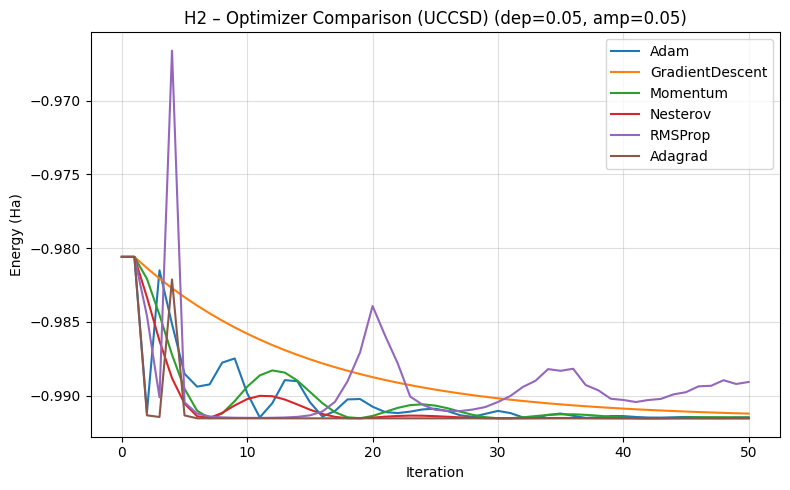

<Figure size 640x480 with 0 Axes>

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2_optimizer_comparison_ansUCCSD_modeconvergence.png


In [2]:
# Optimization settings
optimizers = ["Adam", "GradientDescent", "Momentum", "Nesterov", "RMSProp", "Adagrad"]
steps = 50
stepsize_map = {
    "Adam": 0.2,
    "GradientDescent": 0.05,
    "Momentum": 0.1,
    "Nesterov": 0.1,
    "RMSProp": 0.1,
    "Adagrad": 0.2,
}

comparison = run_vqe_optimizer_comparison(
    molecule="H2",
    ansatz_name="UCCSD",
    optimizers=optimizers,
    steps=steps,
    stepsize=stepsize_map,
    noisy=True,
    depolarizing_prob=depolarizing_prob,
    amplitude_damping_prob=amplitude_damping_prob,
    seed=seed,
    show=True,
    force=False,
)


# ⭐ Part 2 — Identify the Worst Optimizer

Noise flattens the loss landscape, so optimizers behave differently than in
the noiseless case.  

We define the *worst* optimizer as the one with the **highest final energy**.


In [3]:
worst_optimizer = max(
    comparison["final_energies"],
    key=comparison["final_energies"].get
)

print(f"🏆 Worst optimizer under noise: {worst_optimizer}")


🏆 Worst optimizer under noise: RMSProp


# 🔍 Part 3 — Full Noisy VQE Using the Worst Optimizer

We now run a complete noisy VQE with:

- Ansatz: **UCCSD**  
- Optimizer: worst performer  
- Depolarizing: 10%  
- Amplitude damping: 10%  

`run_vqe(...)` returns energies, metadata, and the full **noisy density matrix**.


In [4]:
res = run_vqe(
    molecule="H2",
    ansatz_name="UCCSD",
    optimizer_name=worst_optimizer,
    steps=steps,
    stepsize=stepsize_map[worst_optimizer],
    noisy=True,
    depolarizing_prob=depolarizing_prob,
    amplitude_damping_prob=amplitude_damping_prob,
    seed=seed,
    plot=False,
    force=False,
)

rho = np.array(res["final_state_real"]) + 1j * np.array(res["final_state_imag"])
diag = np.diag(rho)

diag



📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__RMSProp__VQE__noisy__s0__67e4b7f71f35.json


array([6.25373427e-03+0.j, 1.11594666e-03+0.j, 1.11594634e-03+0.j,
       9.69430542e-03+0.j, 6.94111681e-02+0.j, 2.29970649e-03+0.j,
       2.89089122e-03+0.j, 4.10370656e-04+0.j, 6.94111685e-02+0.j,
       2.89089483e-03+0.j, 2.29970649e-03+0.j, 4.10370774e-04+0.j,
       7.79900512e-01+0.j, 2.55247997e-02+0.j, 2.55247996e-02+0.j,
       8.45678711e-04+0.j])

# 🧮 Part 4 — Approximate Ket Representation  

For mixed states, the diagonal entries of ρ correspond to **basis-state
populations**.

We display only those above a small threshold.


In [5]:
threshold = 1e-2
num_wires = int(np.log2(len(diag)))

terms = [
    f"({amp:.4f}|{idx:0{num_wires}b}⟩)"
    for idx, amp in enumerate(diag)
    if abs(amp) > threshold
]

ket_estimate = " + ".join(terms)

print("Approximate noisy state:")
print(f"|ψ⟩ ≈ {ket_estimate}")


Approximate noisy state:
|ψ⟩ ≈ (0.0694+0.0000j|0100⟩) + (0.0694+0.0000j|1000⟩) + (0.7799+0.0000j|1100⟩) + (0.0255+0.0000j|1101⟩) + (0.0255+0.0000j|1110⟩)


# 📊 Part 5 — Basis-State Population Plot

The bar plot below visualizes **which computational states survive** after noise.


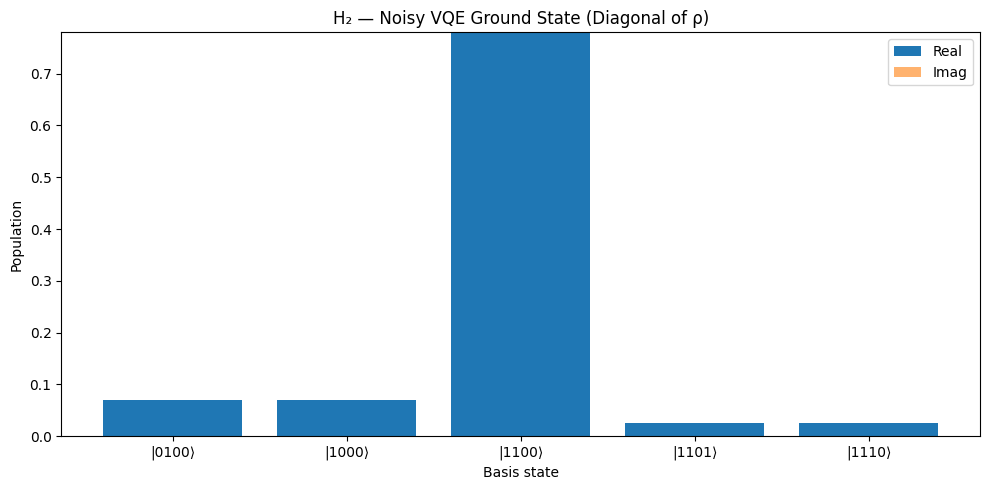

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2_Noisy_Ground_State.png


'/workspaces/Variational_Quantum_Eigensolver/images/vqe/H2_Noisy_Ground_State.png'

In [8]:
indices = np.where(abs(diag) > threshold)[0]
vals = diag[indices]
labels = [f"|{i:0{num_wires}b}⟩" for i in indices]

plt.figure(figsize=(10, 5))
plt.bar(labels, vals.real, label="Real")
plt.bar(labels, vals.imag, bottom=vals.real, alpha=0.6, label="Imag")

plt.xlabel("Basis state")
plt.ylabel("Population")
plt.title("H₂ — Noisy VQE Ground State (Diagonal of ρ)")
plt.legend()
plt.tight_layout()

from vqe_qpe_common.plotting import save_plot
save_plot("H2_Noisy_Ground_State.png", kind="vqe", show=True)
